In [1]:
# import libraries
import numpy as np
import matplotlib.pyplot as plt
# Define seed so get same results each time
np.random.seed(1)

In [2]:
# The true function that we are trying to estimate, defined on [0,1]
def true_function(x):
    y = np.exp(np.sin(x*(2*3.1413)))
    return y

In [3]:
# Generate some data points with or without noise
def generate_data(n_data, sigma_y=0.3):
    # Generate x values quasi uniformly
    x = np.ones(n_data)
    for i in range(n_data):
        x[i] = np.random.uniform(i/n_data, (i+1)/n_data, 1)

    """x는 i/n_data부터 (i+1)/n_data까지 균일 증분 내의 랜덤한 값으로 설정"""
    # y value from running through functoin and adding noise
    y = np.ones(n_data)
    for i in range(n_data):
        y[i] = true_function(x[i])
        y[i] += np.random.normal(0, sigma_y, 1)
    """y값에 Noise 끼게 설정"""
    return x,y

In [4]:
# Draw the fitted function, together win uncertainty used to generate points
def plot_function(x_func, y_func, x_data=None,y_data=None, x_model = None, y_model =None, sigma_func = None, sigma_model=None):

    fig,ax = plt.subplots()
    ax.plot(x_func, y_func, 'k-')
    if sigma_func is not None:
      ax.fill_between(x_func, y_func-2*sigma_func, y_func+2*sigma_func, color='lightgray')

    if x_data is not None:
        ax.plot(x_data, y_data, 'o', color='#d18362')

    if x_model is not None:
        ax.plot(x_model, y_model, '-', color='#7fe7de')

    if sigma_model is not None:
      ax.fill_between(x_model, y_model-2*sigma_model, y_model+2*sigma_model, color='lightgray')

    ax.set_xlim(0,1)
    ax.set_xlabel('Input,')
    ax.set_ylabel('Output,')
    plt.show()
     



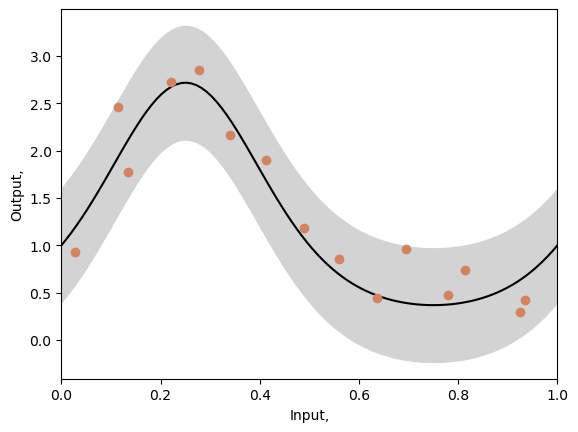

In [5]:
# Generate true function
x_func = np.linspace(0, 1.0, 100)
y_func = true_function(x_func);

# Generate some data points
np.random.seed(1)
"""분산은 상수로 이용되었다"""
sigma_func = 0.3 
n_data = 15
x_data,y_data = generate_data(n_data, sigma_func)

# Plot the functinon, data and uncertainty
plot_function(x_func, y_func, x_data, y_data, sigma_func=sigma_func)

In [6]:
# Define model -- beta is a scalar and omega has size n_hidden,1
def network(x, beta, omega):
    # Retrieve number of hidden units
    n_hidden = omega.shape[0]

    y = np.zeros_like(x)
    for c_hidden in range(n_hidden):
        # Evaluate activations based on shifted lines (figure 8.4b-d)
        line_vals =  x  - c_hidden/n_hidden
        h =  line_vals * (line_vals > 0)
        # Weight activations by omega parameters and sum
        """ Linear Combination """
        y = y + omega[c_hidden] * h
    # Add bias, beta
    y = y + beta

    return y
     
"""그냥 여러 가지 ReLU 함수를 적용했다고 보면 된다. """

In [7]:
# This fits the n_hidden+1 parameters (see fig 8.4a) in closed form.
# If you have studied linear algebra, then you will know it is a least
# squares solution of the form (A^TA)^-1A^Tb.  If you don't recognize that,
# then just take it on trust that this gives you the best possible solution.
def fit_model_closed_form(x,y,n_hidden):
  n_data = len(x)
  A = np.ones((n_data, n_hidden+1))
  for i in range(n_data):
      for j in range(1,n_hidden+1):
          # Compute preactivation
          A[i,j] = x[i]-(j-1)/n_hidden
          # Apply the ReLU function
          if A[i,j] < 0:
              A[i,j] = 0;

  # Add a tiny bit of regularization
  reg_value = 0.00001
  regMat = reg_value * np.identity(n_hidden+1)
  regMat[0,0] = 0

  ATA = np.matmul(np.transpose(A), A) +regMat
  ATAInv = np.linalg.inv(ATA)
  ATAInvAT = np.matmul(ATAInv, np.transpose(A))
  beta_omega = np.matmul(ATAInvAT,y) #################### ((X.T) x X)^{-1} X.T y로 가중치 closed form으로 구하기
  beta = beta_omega[0]
  omega = beta_omega[1:]

  return beta, omega

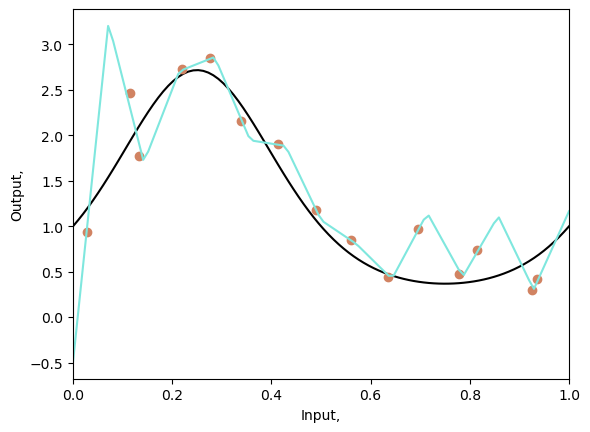

Mean square error = 0.195


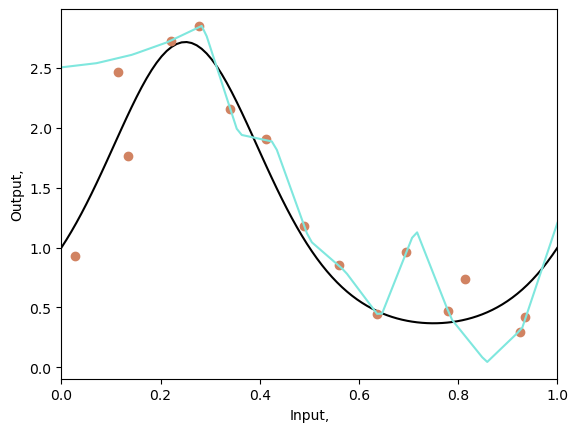

Mean square error = 0.222


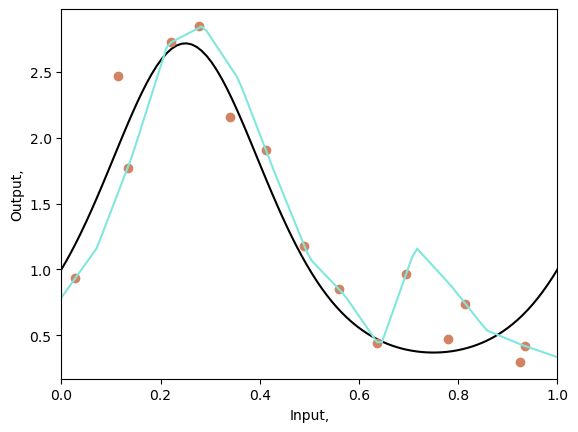

Mean square error = 0.098


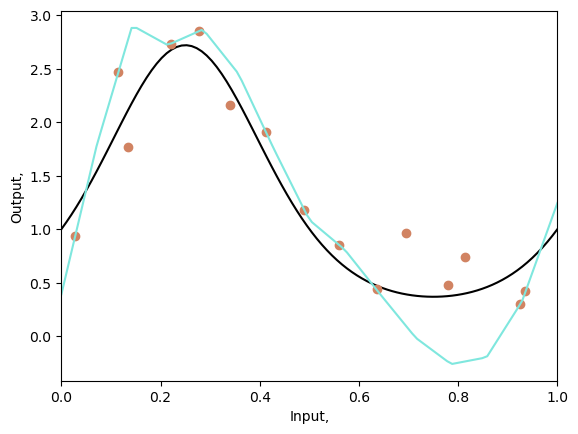

Mean square error = 0.120


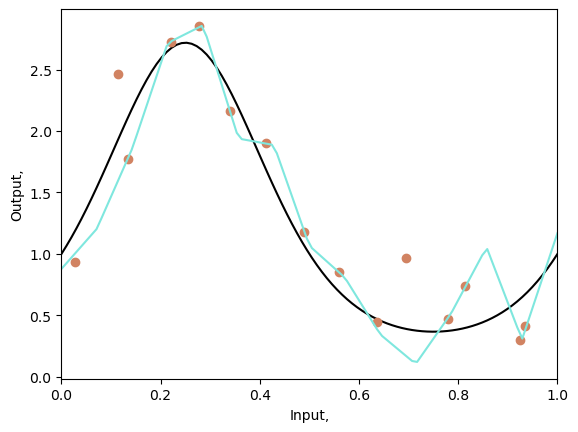

Mean square error = 0.048


In [8]:
# Closed form solution
beta, omega = fit_model_closed_form(x_data,y_data,n_hidden=14)

# Get prediction for model across graph grange
x_model = np.linspace(0,1,100);
y_model = network(x_model, beta, omega)

# Draw the function and the model
plot_function(x_func, y_func, x_data,y_data, x_model, y_model)

"""Closed Form model으로 그림을 그림"""

# Compute the mean squared error between the fitted model (cyan) and the true curve (black)
mean_sq_error = np.mean((y_model-y_func) * (y_model-y_func))
print(f"Mean square error = {mean_sq_error:3.3f}")
     

# Now let's resample the data with replacement four times.
n_model = 4
# Array to store the prediction from all of our models
all_y_model = np.zeros((n_model, len(y_model)))

# For each model
for c_model in range(n_model):
    """TODO Sample data indices with replacement (use np.random.choice)"""
    # Replace this line
    resampled_indices = np.random.choice(range(n_data), size=n_data, replace=True)

    # Extract the resampled x and y data
    """Resampling"""
    x_data_resampled = x_data[resampled_indices]
    y_data_resampled = y_data[resampled_indices]

    # Fit the model
    """Resample Data로 다시 모델을 fitting함, ReLU에 들어갈 선형 모델의 가중치 구함"""
    beta, omega = fit_model_closed_form(x_data_resampled,y_data_resampled,n_hidden=14)

    # Run the model
    """모델을 ReLU로 이루어진 신경망에 통과"""
    y_model_resampled = network(x_model, beta, omega)

    # Store the results
    all_y_model[c_model,:] = y_model_resampled

    # Draw the function and the model
    plot_function(x_func, y_func, x_data,y_data, x_model, y_model_resampled)

    # Compute the mean squared error between the fitted model (cyan) and the true curve (black)
    mean_sq_error = np.mean((y_model_resampled-y_func) * (y_model_resampled-y_func))
    print(f"Mean square error = {mean_sq_error:3.3f}")
     
"""이렇게 여러 Linear Combination 모델을 구하고"""
""" 다음 블록에서 Combining 할 것 """

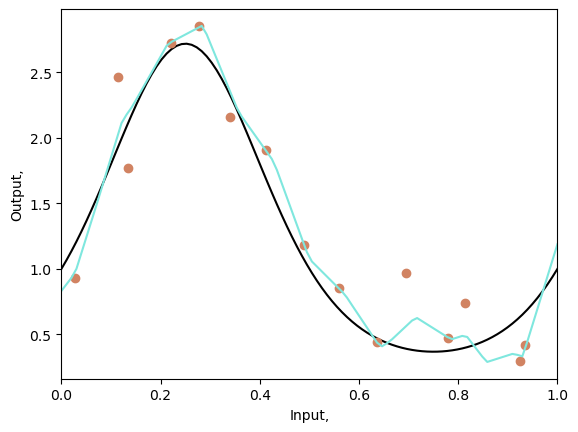

Mean square error(median) = 0.020


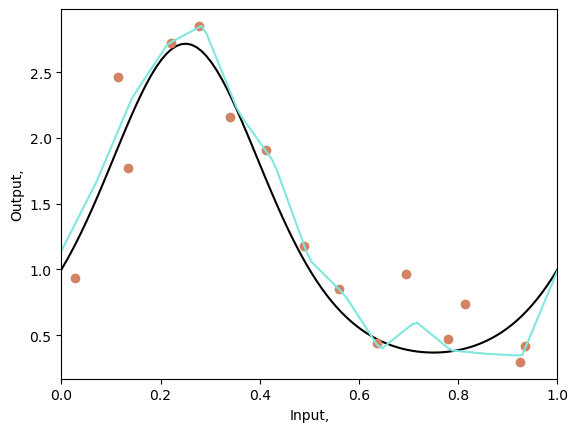

Mean square error(mean) = 0.018


In [10]:
# Plot the median of the results
# TODO -- find the median prediction
# Replace this line
y_model_median = np.median(all_y_model, axis=0)

# Draw the function and the model
plot_function(x_func, y_func, x_data,y_data, x_model, y_model_median)

"""중간값으로 y값 Ensemble"""
# Compute the mean squared error between the fitted model (cyan) and the true curve (black)
mean_sq_error = np.mean((y_model_median-y_func) * (y_model_median-y_func))
print(f"Mean square error(median) = {mean_sq_error:3.3f}")

# Plot the median of the results
# TODO -- find the mean prediction
# Replace this line
"""평균값으로 y값 Ensemble"""
y_model_mean = np.mean(all_y_model, axis=0)

# Draw the function and the model
plot_function(x_func, y_func, x_data,y_data, x_model, y_model_mean)

# Compute the mean squared error between the fitted model (cyan) and the true curve (black)
mean_sq_error = np.mean((y_model_mean-y_func) * (y_model_mean-y_func))
print(f"Mean square error(mean) = {mean_sq_error:3.3f}")

"""
거의 Fitting이 완료된 모습 확인 가능
Deep Learning 자체도 Logistic Regression의 Ensemble 이지만

또 그 Deep Learning Model을 다시 Ensemble 하는 것이 가능하다.
이런 Technic은 CNN에서 여러 필터들과 함께 사용될 것 
"""